In [1]:
# Standard Libraries
import shutil
import urllib.request as urlrequest
from collections import Counter
from pathlib import Path
from pprint import pprint
from zipfile import ZipFile
import zipfile
from datetime import datetime
import datetime
import ast
# 3rd-party Libraries
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import make_scorer,recall_score, roc_curve, roc_auc_score
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tensorflow import keras

2023-05-02 16:58:28.609167: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-02 16:58:31.580502: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-02 16:58:31.581781: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 16:58:36.856253: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def read_file(file_path):
    if file_path.endswith('.zip'):
        with zipfile.ZipFile(file_path, 'r') as zfile:
            tsv_files = [f for f in zfile.namelist() if f.endswith('.tsv')]
            if len(tsv_files) == 0:
                raise ValueError("No TSV files found in the zip file.")
            elif len(tsv_files) > 1:
                raise ValueError("Zip file must contain exactly one TSV file.")
            
            with zfile.open(tsv_files[0]) as file:
                df = pd.read_csv(file, sep='\t')
    elif file_path.endswith('.tsv'):
        df = pd.read_csv(file_path, sep='\t')
    else:
        raise ValueError("Unsupported file format. Only .zip and .tsv files are supported.")

    return df


# Usage
file_path = 'JOURNALISM_20230401_to_20230425_7e4c492_session-features.zip'  # Replace with your file path
raw_data = read_file(file_path)
raw_data

,PlayerID,SessionID,PlayTime,PlayTime-Total Time,PlayTime-Idle Time,PlayerAttributes,QuitLevel,QuitLevel-EventName,QuitLevel-NodeID,QuitType,...,lvl3_LevelCompleted,lvl4_LevelCompleted,lvl5_LevelCompleted,lvl1_LevelStoryAlignment,lvl2_LevelStoryAlignment,lvl3_LevelStoryAlignment,lvl4_LevelStoryAlignment,lvl5_LevelStoryAlignment,ContinuesOnFail,GameComplete
0,NaN,23040610403968878,0:00:32.210000,0:01:33.265000,0:01:01.055000,"[1,2,1,2,1,1]",0,complete_level,none,Other,...,False,False,False,0.0,0.0,0.0,0.0,0.0,10,False
1,NaN,23040711302424298,0:02:43.373000,0:02:43.373000,0:00:00,"[2,3,4,3,2,7]",3,change_location,none,OnFail,...,True,True,True,0.0,0.0,0.0,0.0,0.0,33,True
2,NaN,23040713291247534,0:00:58.817000,0:00:58.817000,0:00:00,"[0, 0, 0, 0, 0, 0]",4,display_choices,none,Other,...,False,False,False,0.0,0.0,0.0,0.0,0.0,0,False
3,NaN,23040713304788545,0:01:44.579000,0:01:44.579000,0:00:00,"[0, 0, 0, 0, 0, 0]",4,text_click,RemindTheMayor,OnFail,...,False,False,False,0.0,0.0,0.0,0.0,0.0,0,False
4,SeveralFridge,23040212171216016,0:00:00.708000,0:00:00.708000,0:00:00,"[0, 0, 0, 0, 0, 0]",0,display_text_dialog,@0C9004F8,Other,...,False,False,False,0.0,0.0,0.0,0.0,0.0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,AbnormalDozen,23042113214030054,0:02:53.267000,0:02:53.267000,0:00:00,"[1,3,1,2,2,2]",0,display_text_dialog,SnagPhotosLowTime,Other,...,False,False,False,0.0,0.0,0.0,0.0,0.0,0,False
786,FondToad,23042114180700609,0:04:14.894000,0:04:14.894000,0:00:00,"[1,3,1,2,2,2]",0,display_choices,none,Other,...,False,False,False,0.0,0.0,0.0,0.0,0.0,0,False
787,CottonyStylus,23042114321567240,0:02:07.005000,0:02:07.005000,0:00:00,"[1,2,1,1,3,3]",0,time_expired,TakeSomePhotos,Other,...,False,False,False,0.0,0.0,0.0,0.0,0.0,0,False
788,AdoredSlip,23042114323708674,0:01:52.754000,0:01:52.754000,0:00:00,"[1,1,2,1,3,3]",0,stat_update,ChaseChickens,Other,...,False,False,False,0.0,0.0,0.0,0.0,0.0,0,False


In [3]:
rows_to_show = 10
pd.set_option('display.max_columns', None)

raw_data.head(rows_to_show)

,PlayerID,SessionID,PlayTime,PlayTime-Total Time,PlayTime-Idle Time,PlayerAttributes,QuitLevel,QuitLevel-EventName,QuitLevel-NodeID,QuitType,QuitType-BetweenLevels,QuitType-OnFail,QuitType-OnCheckpoint,QuitType-Other,SkillSequenceCount,SkillSequenceCount-Event Sequence,TopAttribute,TopAttribute-Names,TotalFails,WorstAttribute,WorstAttribute-Names,lvl1_AttributeView,lvl2_AttributeView,lvl3_AttributeView,lvl4_AttributeView,lvl5_AttributeView,lvl1_EditorNoteOpen,lvl2_EditorNoteOpen,lvl3_EditorNoteOpen,lvl4_EditorNoteOpen,lvl5_EditorNoteOpen,lvl1_FailureCount,lvl1_FailureCount-OutOfTime,lvl1_FailureCount-LowAttribute,lvl2_FailureCount,lvl2_FailureCount-OutOfTime,lvl2_FailureCount-LowAttribute,lvl3_FailureCount,lvl3_FailureCount-OutOfTime,lvl3_FailureCount-LowAttribute,lvl4_FailureCount,lvl4_FailureCount-OutOfTime,lvl4_FailureCount-LowAttribute,lvl5_FailureCount,lvl5_FailureCount-OutOfTime,lvl5_FailureCount-LowAttribute,lvl1_LevelCompleted,lvl2_LevelCompleted,lvl3_LevelCompleted,lvl4_LevelCompleted,lvl5_LevelCompleted,lvl1_LevelStoryAlignment,lvl2_LevelStoryAlignment,lvl3_LevelStoryAlignment,lvl4_LevelStoryAlignment,lvl5_LevelStoryAlignment,ContinuesOnFail,GameComplete
0,NaN,23040610403968878,0:00:32.210000,0:01:33.265000,0:01:01.055000,"[1,2,1,2,1,1]",0,complete_level,none,Other,False,False,False,True,27,"[{""skill"": ""{\""Research\"":0,\""Resourceful\"":1,...",2,"['resourceful', 'social']",10,1,"['endurance', 'tech', 'trust', 'research']",0,0,0,0,0,0,0,0,0,0,10,6,4,0,0,0,0,0,0,0,0,0,0,0,0,True,False,False,False,False,0.000,0.000,0.000,0.00,0.0,10,False
1,NaN,23040711302424298,0:02:43.373000,0:02:43.373000,0:00:00,"[2,3,4,3,2,7]",3,change_location,none,OnFail,False,True,False,False,169,"[{""skill"": ""{\""Research\"":1,\""Resourceful\"":0,...",7,['research'],34,2,"['endurance', 'trust']",0,0,0,0,0,0,0,0,0,0,12,10,2,0,0,0,18,0,18,0,0,0,4,0,4,True,True,True,True,True,0.000,0.000,0.000,0.00,0.0,33,True
2,NaN,23040713291247534,0:00:58.817000,0:00:58.817000,0:00:00,"[0, 0, 0, 0, 0, 0]",4,display_choices,none,Other,False,False,False,True,0,[],0,[],0,0,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,False,False,False,0.000,0.000,0.000,0.00,0.0,0,False
3,NaN,23040713304788545,0:01:44.579000,0:01:44.579000,0:00:00,"[0, 0, 0, 0, 0, 0]",4,text_click,RemindTheMayor,OnFail,False,True,False,False,0,[],0,[],1,0,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,False,False,False,False,False,0.000,0.000,0.000,0.00,0.0,0,False
4,SeveralFridge,23040212171216016,0:00:00.708000,0:00:00.708000,0:00:00,"[0, 0, 0, 0, 0, 0]",0,display_text_dialog,@0C9004F8,Other,False,False,False,True,0,[],0,[],0,0,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,False,False,False,0.000,0.000,0.000,0.00,0.0,0,False
5,EnoughRally,23040214002714806,0:43:39.086000,0:43:39.086000,0:00:00,"[3,3,5,3,4,1]",5,display_text_dialog,@0C9004F8,OnFail,False,True,False,False,16,"[{""skill"": ""{\""Research\"":0,\""Resourceful\"":0,...",5,['tech'],2,1,['research'],1,4,1,1,3,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,True,True,True,True,False,0.229,0.800,0.633,0.34,0.0,1,False
6,SmartestIcicle,23040215195158578,0:41:06.259000,0:41:06.259000,0:00:00,"[1,4,5,4,4,0]",5,display_text_dialog,@0C9004F8,Other,False,False,False,True,15,"[{""skill"": ""{\""Research\"":0,\""Resourceful\"":1,...",5,['tech'],1,0,['research'],0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,True,True,True,True,False,-0.031,0.559,0.300,0.00,0.0,1,False
7,QuickFax,23040216160241931,0:01:31.366000,0:01:31.366000,0:00:00,"[1,2,2,1,1,1]",0,stat_update,@0C9004F8,Other,False,False,False,True,1,"[{""skill"": ""{\""Research\"":0,\""Resourceful\"":1,...",2,"['resourceful', 'tech']",0,1,"['endurance', 'social', 'trust', 'research']",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,False,False,False,0.000,0.000,0.000,0.00,0.0,0,False
8,CirclingPencil,23040216182351934,0:08:19.177000,0:10:13.122000,0:01:53.945000,"[1,3,1,2,2,2]",1,text_click,@0C9004F8,Other,False,False,False,True,2,"[

In [4]:
df_session = raw_data.dropna()
for col in df_session.columns:
    dtype = df_session[col].dtype
    if dtype == bool:
        # convert the boolean column to integer (1 for True and 0 for False)
        df_session[col] = df_session[col].astype(int)

def convert_to_seconds(time_str):
    try:
        time_obj = datetime.datetime.strptime(time_str, '%H:%M:%S.%f').time()
        timedelta_obj = datetime.timedelta(hours=time_obj.hour, minutes=time_obj.minute, seconds=time_obj.second, microseconds=time_obj.microsecond)
        return timedelta_obj.total_seconds()
    except ValueError:
        return None

df_session['PlayTime'] = df_session['PlayTime'].apply(convert_to_seconds)

df_session['PlayTime-Total Time'] = df_session['PlayTime-Total Time'].apply(convert_to_seconds)
df_session['PlayTime-Idle Time'] = df_session['PlayTime-Idle Time'].apply(convert_to_seconds)


/tmp/ipykernel_463/1596649867.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_session[col] = df_session[col].astype(int)
/tmp/ipykernel_463/1596649867.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_session[col] = df_session[col].astype(int)
/tmp/ipykernel_463/1596649867.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

# How far did people get?

/tmp/ipykernel_463/2612279508.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_session[target_cols].hist(ax=ax, bins = 2)


array([[<Axes: title={'center': 'lvl1_LevelCompleted'}>,
        <Axes: title={'center': 'lvl2_LevelCompleted'}>],
       [<Axes: title={'center': 'lvl3_LevelCompleted'}>,
        <Axes: title={'center': 'lvl4_LevelCompleted'}>],
       [<Axes: title={'center': 'lvl5_LevelCompleted'}>, <Axes: >]],
      dtype=object)

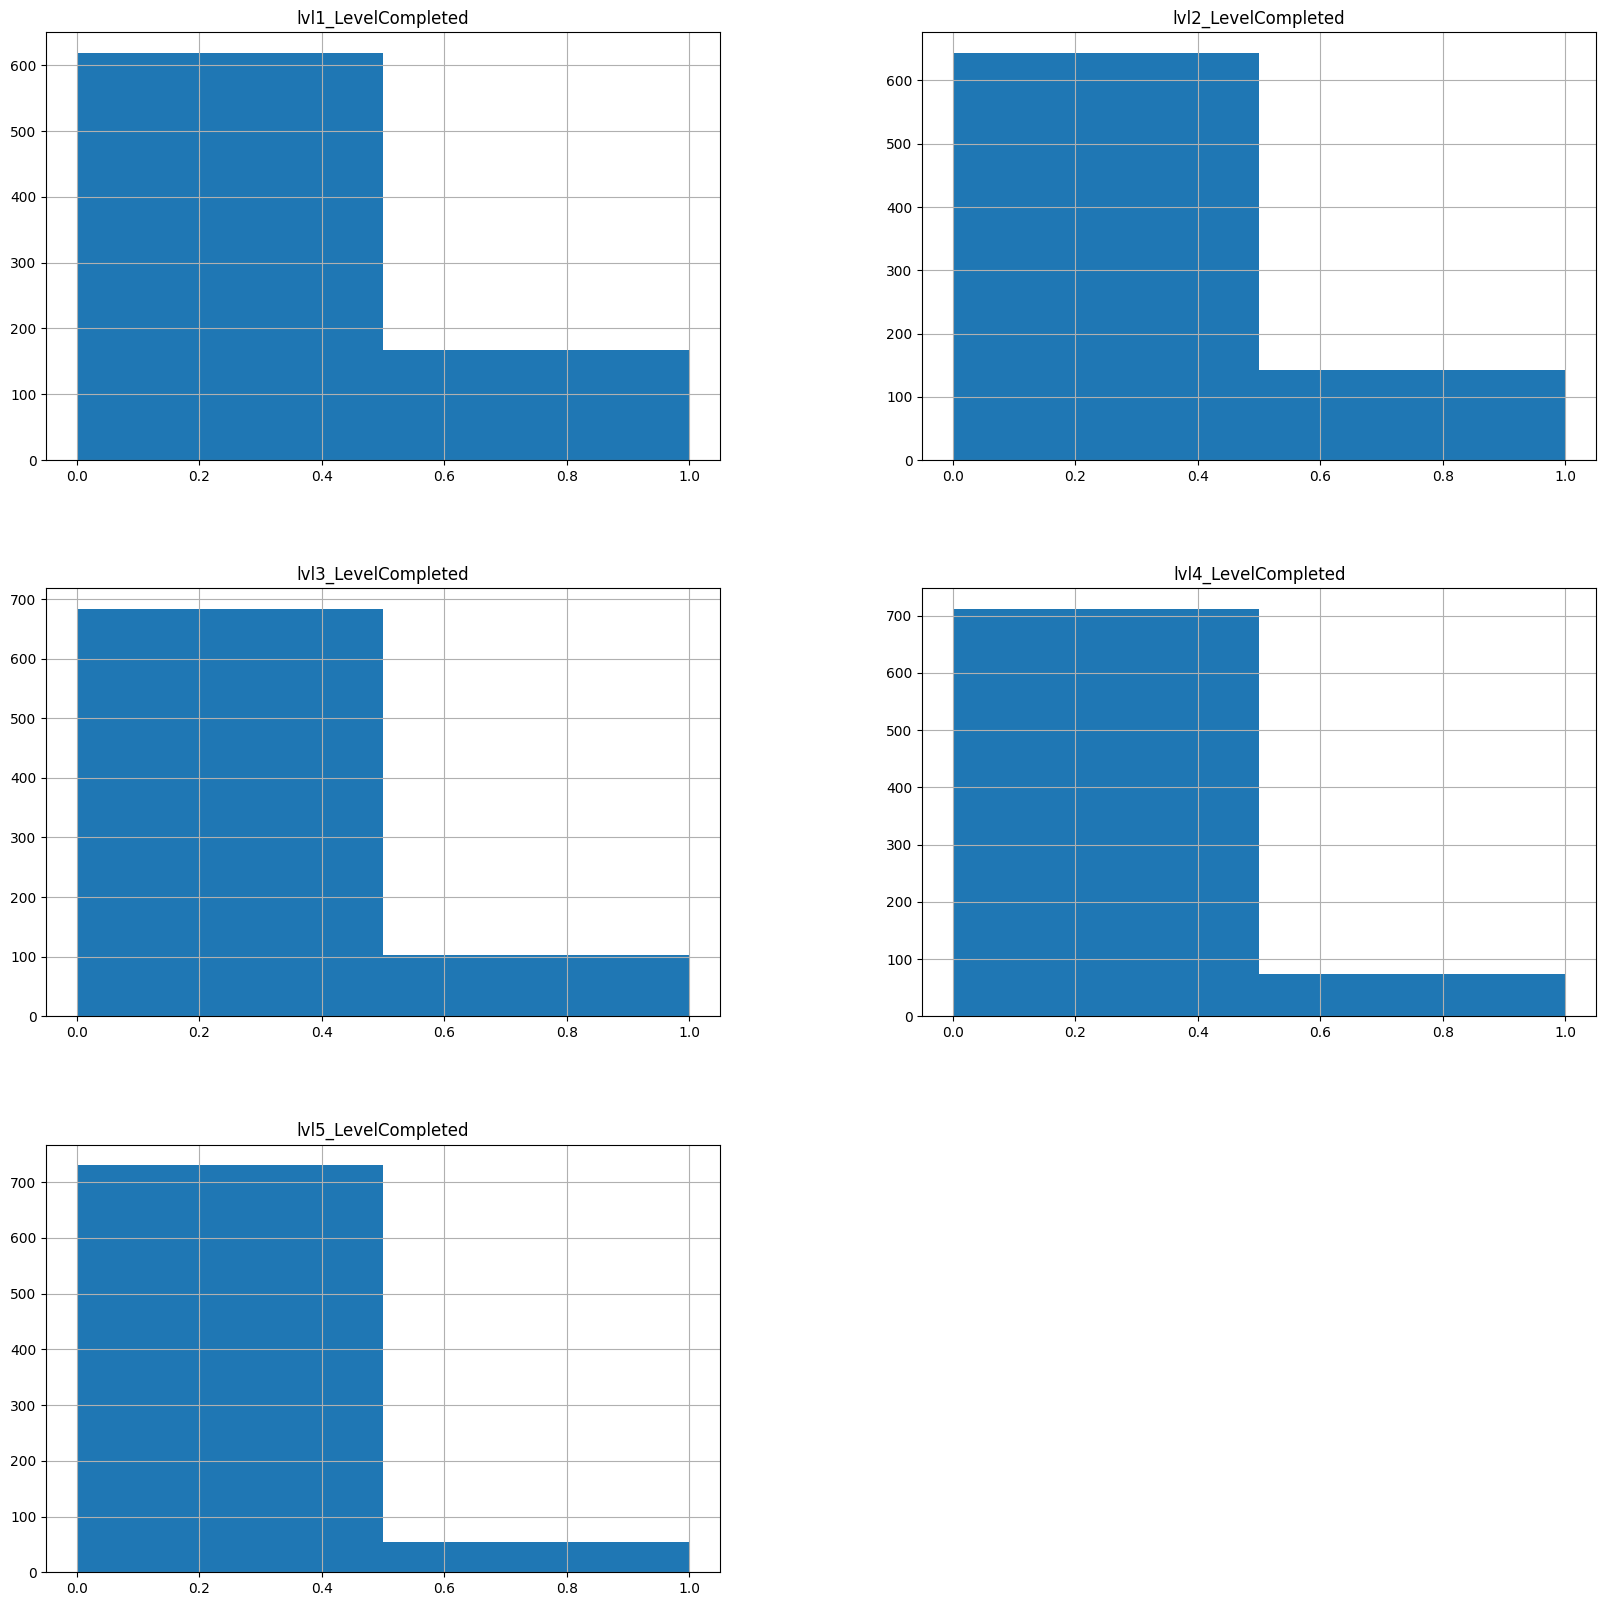

In [5]:
target_cols = ['lvl1_LevelCompleted', 'lvl2_LevelCompleted', 'lvl3_LevelCompleted',
       'lvl4_LevelCompleted', 'lvl5_LevelCompleted']
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
df_session[target_cols].hist(ax=ax, bins = 2)


# How far do people get?

The average amount of levels completed: 1.7048346055979644


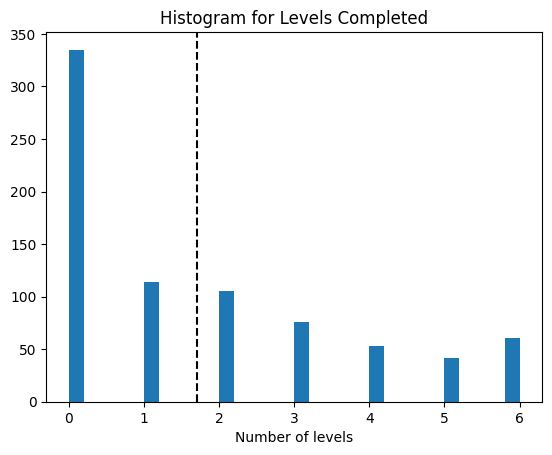

In [42]:
df_column = df_session['QuitLevel'] #column must be integers
#jobs completed
f, ax = plt.subplots()
ax.hist(df_column, bins=30)
ax.axvline(x=df_column.mean(), linestyle='--', color='k', label="Median")
ax.set_xlabel("Number of levels")
ax.set_title("Histogram for Levels Completed")
print(f'The average amount of levels completed: {df_column.mean()}')

# How did people play the game?

In [16]:
top_counts = {}

# Iterate over each row in the DataFrame
for list in df_session['TopAttribute-Names']:
    list = ast.literal_eval(list)
# Convert the string to a list
    for value in list:
        if value in top_counts:
            top_counts[value] += 1
        else:
            top_counts[value] = 1
top_counts

{'tech': 155,
 'resourceful': 306,
 'research': 191,
 'social': 108,
 'endurance': 51,
 'trust': 144}

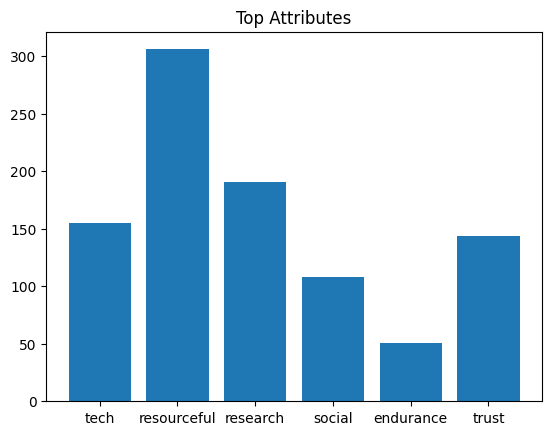

In [25]:
plt.bar(top_counts.keys(), top_counts.values())
plt.title("Top Attributes")
plt.show()

In [26]:
worst_counts = {}

# Iterate over each row in the DataFrame
for list in df_session['WorstAttribute-Names']:
    list = ast.literal_eval(list)
# Convert the string to a list
    for value in list:
        if value in worst_counts:
            worst_counts[value] += 1
        else:
            worst_counts[value] = 1
worst_counts

{'research': 192,
 'endurance': 411,
 'social': 191,
 'trust': 130,
 'tech': 231,
 'resourceful': 62}

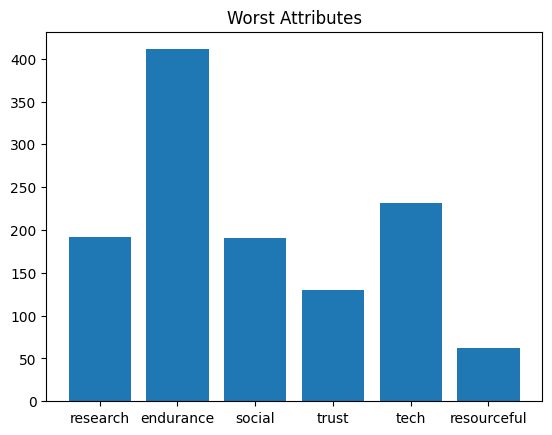

In [27]:
plt.bar(worst_counts.keys(), worst_counts.values())
plt.title("Worst Attributes")
plt.show()


In [38]:
attribute_values = {}
for index, row in df_session.iterrows():
    attribute_name = row['TopAttribute-Names']
    attribute_name = ast.literal_eval(attribute_name)
    attribute_value = row['TopAttribute']
    for att in attribute_name:
        attribute_values[att] = attribute_value
attribute_values

{'tech': 2,
 'resourceful': 3,
 'research': 2,
 'social': 2,
 'endurance': 5,
 'trust': 2}

The average amount of levels completed: 1.7048346055979644


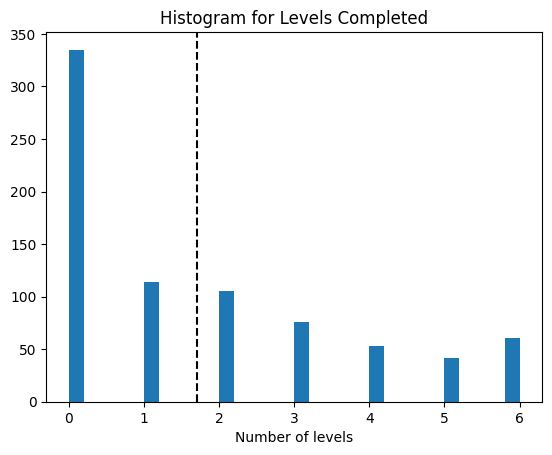

In [29]:
df_column = df_session['QuitLevel'] #column must be integers
#jobs completed
f, ax = plt.subplots()
ax.hist(df_column, bins=30)
ax.axvline(x=df_column.mean(), linestyle='--', color='k', label="Median")
ax.set_xlabel("Number of levels")
ax.set_title("Histogram for Levels Completed")
print(f'The average amount of levels completed: {df_column.mean()}')